Graph is connected: True
0.06696629102839327
[[-0.47510441]
 [ 0.88421757]
 [ 0.625     ]
 [ 0.47619048]
 [ 0.66666667]
 [-0.37037037]
 [-0.40063334]
 [-0.47619048]
 [-0.71428571]
 [ 0.21566053]
 [ 0.47619048]
 [-0.07732321]
 [-0.625     ]
 [ 0.12838166]
 [ 0.36953351]
 [ 0.625     ]
 [-0.29148182]
 [-0.31710537]
 [ 0.12370746]
 [-0.5       ]
 [ 0.47619048]
 [-0.29550143]
 [ 0.47619048]
 [-0.38461538]
 [ 0.05241572]
 [ 0.50013814]
 [ 0.25451763]
 [ 0.41666667]
 [ 0.37037037]
 [-0.20823349]
 [ 0.71428571]
 [ 0.28931151]
 [-0.38461538]
 [ 0.43478261]
 [-0.5       ]
 [-0.52631579]
 [ 0.71428571]
 [-0.34482759]
 [-0.41429093]
 [-0.58823529]
 [ 0.25334024]
 [ 0.2783081 ]
 [-0.07041728]
 [ 0.16125844]
 [ 0.04546143]
 [-0.41666667]
 [-0.66666667]
 [ 0.08151686]
 [-0.625     ]
 [ 0.38461538]
 [ 0.37037037]
 [-0.55555556]
 [-0.41666667]
 [ 0.52631579]
 [-0.43478261]
 [ 0.3895165 ]
 [-0.38461538]
 [-0.18827619]
 [ 0.3430426 ]
 [ 0.4       ]
 [-0.45454545]
 [ 0.38461538]
 [ 0.16588124]
 [ 0.34482

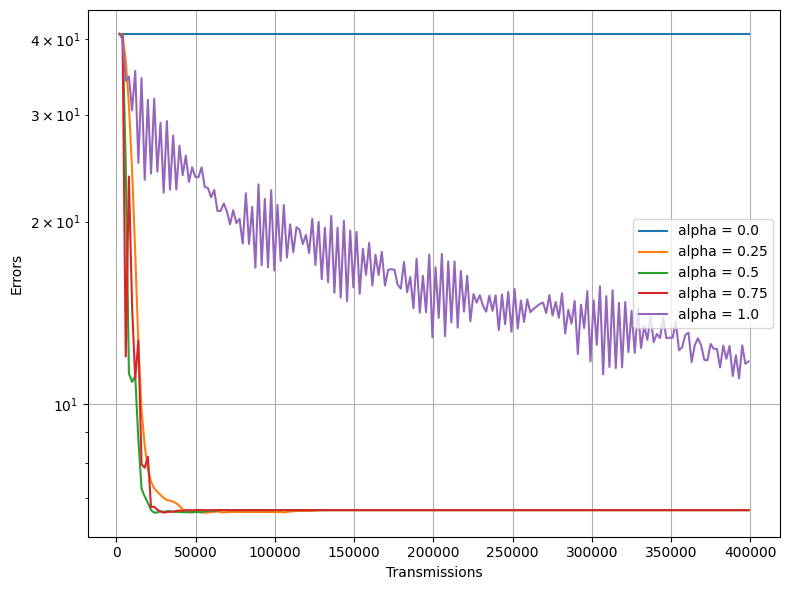

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import cvxpy as cp

N = 100 # number of  nodes or sensors
R = 30 # radius of the communication range
L = 100 # length of the square area

x_gt = 0 # ground truth value for node data
x_cov = 1 # covariance of the sample


# random generate points uniformly in a square
points = np.random.uniform(0, L, size=(N, 2))
# check connectivity
G = nx.Graph()
G.add_nodes_from(range(N))
# add edges based on distance
for i in range(N):
    for j in range(i + 1, N):
        if np.linalg.norm(points[i] - points[j]) <= R:
            G.add_edge(i, j)

# check if connected
is_connected = nx.is_connected(G)
print(f"Graph is connected: {is_connected}")

MAX_ITERS = int(2e2)

x_init = (x_gt + np.random.randn(N)*np.sqrt(x_cov)).reshape(N, 1) # initial obs

def pdmm_median(
        x_init,        
        a,              
        G,               
        c=1.0,        
        max_iters=int(1e3),
        alpha=0.5
    ):

    x = x_init.copy().astype(float)
    n = len(x)
    deg = np.array([G.degree[i] for i in range(n)])


    edges_dir = [(i, j) for i, j in G.edges()] + [(j, i) for i, j in G.edges()]
    z = {e: 0.0 for e in edges_dir}

    med = np.median(a)
    errors = []
    transmissions = []
    m_dir = len(edges_dir)              

    for k in range(max_iters):
        
        for i in range(n):
            s = sum(z[(i, j)] for j in G.neighbors(i))
            g = s/(c*deg[i])
            if - g - 1/(c*deg[i]) > a[i]:
                x[i] = - g - 1/(c*deg[i])
            elif - g + 1/(c*deg[i]) < a[i] :
                x[i] = - g + 1/(c*deg[i])
            else:
                x[i] = a[i]


        errors.append(np.sum(np.abs(x - med)))



        y = {e: z[e] + 2.0 * c * x[e[0]] for e in edges_dir}
        for i, j in edges_dir:
            z[(j, i)] = (1-alpha)*z[(j, i)] + alpha*y[(i, j)]

        transmissions.append(transmissions[-1] + m_dir if transmissions else m_dir)
    print(med)
    print(x)
    return errors, transmissions

cs = np.linspace(0, 1, 5)

plt.figure(figsize=(8, 6))
error_list_c = []
for c in cs:
    pdmm_err, pdmm_tx = pdmm_median(x_init, x_init, G, c=0.1, max_iters=MAX_ITERS, alpha=c)
    error_list_c.append(pdmm_err[-1])
    label = f'alpha = {c}'
    plt.semilogy(pdmm_tx, pdmm_err, marker='', label=label)
plt.xlabel('Transmissions')
plt.ylabel('Errors')
plt.legend()
plt.grid(True)
#plt.gca().set_aspect(2e4)
plt.tight_layout()
plt.savefig('pdmm_median.pdf')